In [1]:
from scipy import stats, sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
ROOT = Path('.').absolute().parent
DATA_DIR = ROOT / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'

In [3]:
[*RAW_DATA_DIR.rglob('*')]

[PosixPath('/home/acapelo/Projects/datasci4health/data/raw/train'),
 PosixPath('/home/acapelo/Projects/datasci4health/data/raw/.ipynb_checkpoints'),
 PosixPath('/home/acapelo/Projects/datasci4health/data/raw/test'),
 PosixPath('/home/acapelo/Projects/datasci4health/data/raw/egfr_erbB1.h5'),
 PosixPath('/home/acapelo/Projects/datasci4health/data/raw/train/sparse_train_X.npz'),
 PosixPath('/home/acapelo/Projects/datasci4health/data/raw/train/sparse_train_y.npz'),
 PosixPath('/home/acapelo/Projects/datasci4health/data/raw/test/sparse_test_y.npz'),
 PosixPath('/home/acapelo/Projects/datasci4health/data/raw/test/sparse_test_X.npz')]

# Load raw data

In [4]:
train_X_csr = sparse.load_npz(RAW_DATA_DIR / 'train' / 'sparse_train_X.npz')
train_y_csr = sparse.load_npz(RAW_DATA_DIR / 'train' / 'sparse_train_y.npz')

**To numpy arrays**

In [5]:
train_X = train_X_csr.toarray()
train_y = train_y_csr.toarray().squeeze()

# Modelling pipelines

## Try different tree based algorithms

In [6]:
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
    AdaBoostClassifier)
from sklearn.model_selection import RandomizedSearchCV

### Based on Bagging

In [28]:
bagging_param_distribs = {
    'n_estimators': stats.randint(50, 250),
    'criterion': ['gini', 'entropy'],
    'max_depth': stats.randint(1, 20),
    'min_samples_leaf': stats.randint(5, 50),
    'max_samples': stats.loguniform(3e-1, 1)
}

In [29]:
bagging_estimators = {
    'xtrees': ExtraTreesClassifier(random_state=123),
    'rf': RandomForestClassifier(random_state=123)
}
search_objs = {}

for name, estimator in bagging_estimators.items():
    rnd_search_cv = RandomizedSearchCV(estimator,
                                       param_distributions=bagging_param_distribs,
                                       scoring='accuracy', cv=5, n_iter=50, random_state=123,
                                       return_train_score=True, verbose=2, n_jobs=-1)
    rnd_search_cv.fit(train_X, train_y)
    search_objs[name] = rnd_search_cv

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [30]:
search_objs['rf'].cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_max_samples', 'param_min_samples_leaf', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [31]:
top_n = 5

for name in bagging_estimators:
    print(name, '-'*50)
    cv_test_scores = search_objs[name].cv_results_['mean_test_score']
    top_results_idx = [*reversed(np.argsort(cv_test_scores))][:top_n]
    for i, idx in enumerate(top_results_idx):
        print(f'# {i}')
        print('test_score: {:.4f}'.format(cv_test_scores[idx]))
        for param in bagging_param_distribs:
            param_samples = search_objs[name].cv_results_[f'param_{param}']
            print(f'{param}: ', param_samples[idx])

xtrees --------------------------------------------------
# 0
test_score: 0.8232
n_estimators:  189
criterion:  gini
max_depth:  18
min_samples_leaf:  8
max_samples:  0.6879025773510774
# 1
test_score: 0.8114
n_estimators:  155
criterion:  gini
max_depth:  16
min_samples_leaf:  12
max_samples:  0.6439261050375636
# 2
test_score: 0.8111
n_estimators:  159
criterion:  entropy
max_depth:  13
min_samples_leaf:  11
max_samples:  0.9349802999603081
# 3
test_score: 0.8099
n_estimators:  186
criterion:  entropy
max_depth:  18
min_samples_leaf:  15
max_samples:  0.6679884088472051
# 4
test_score: 0.8056
n_estimators:  138
criterion:  entropy
max_depth:  13
min_samples_leaf:  12
max_samples:  0.47413993117704734
rf --------------------------------------------------
# 0
test_score: 0.8114
n_estimators:  189
criterion:  gini
max_depth:  18
min_samples_leaf:  8
max_samples:  0.6879025773510774
# 1
test_score: 0.7971
n_estimators:  73
criterion:  gini
max_depth:  11
min_samples_leaf:  8
max_samples:

## Get best model

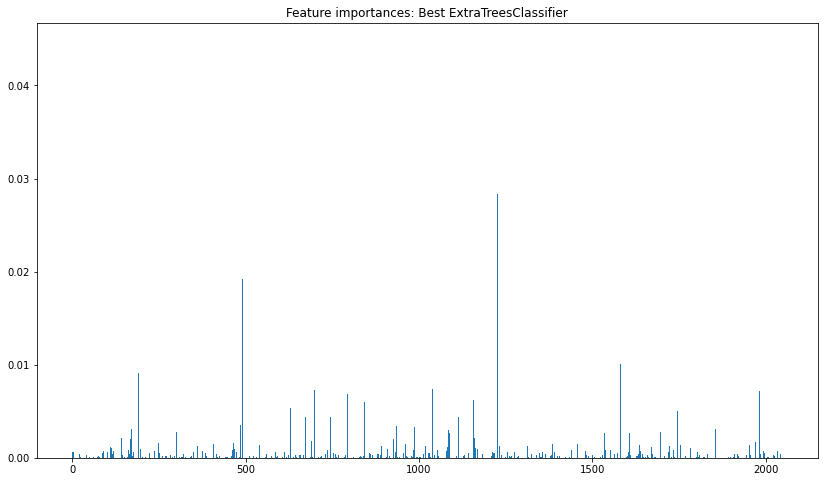

In [35]:
plt.figure(figsize=(14,8))
plt.bar(range(2048), search_objs['xtrees'].best_estimator_.feature_importances_)
plt.title('Feature importances: Best ExtraTreesClassifier');

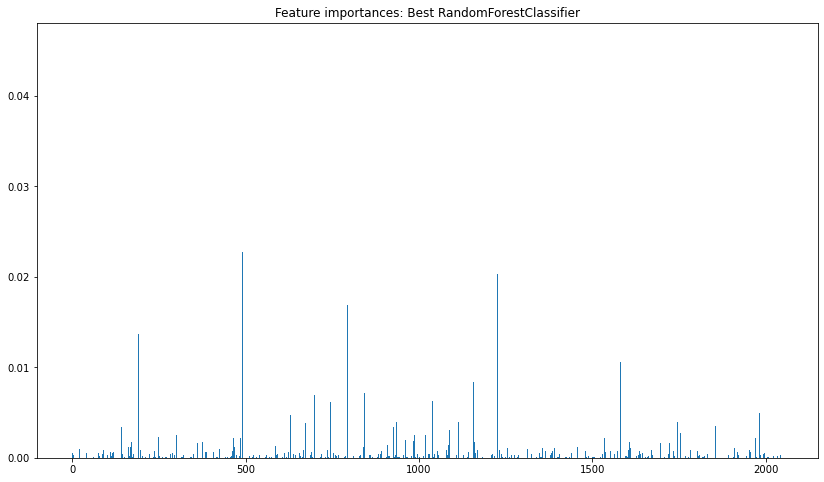

In [37]:
plt.figure(figsize=(14,8))
plt.bar(range(2048), search_objs['rf'].best_estimator_.feature_importances_)
plt.title('Feature importances: Best RandomForestClassifier');

## Save best model

In [38]:
import joblib

In [39]:
best_xtrees_model = search_objs['xtrees'].best_estimator_
best_xtrees_model_path = ROOT / 'models' / 'sample_xtrees.joblib'
joblib.dump(best_xtrees_model, best_xtrees_model_path)

['/home/acapelo/Projects/datasci4health/models/sample_xtrees.joblib']

In [40]:
best_rf_model = search_objs['rf'].best_estimator_
best_rf_model_path = ROOT / 'models' / 'sample_rf.joblib'
joblib.dump(best_rf_model, best_rf_model_path)

['/home/acapelo/Projects/datasci4health/models/sample_rf.joblib']

### Based on Boosting

In [ ]:
estimator_params = {
    'xtrees': ['n_estimators', 'criterion', 'max_depth', 'min_samples_leaf', 'max_features', 'max_samples', 'warm_start'],
    'rf': ['n_estimators', 'criterion', 'max_depth', 'min_samples_leaf', 'max_features', 'max_samples', 'warm_start'],
    'adaboost': ['n_estimators', 'learning_rate']
    'lightgbm': ['learning_rate', 'max_depth', 'n_estimators', 'min_child_samples', ]
}

boosting_parm_distribs = {
    'learning_rate'
}